<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/28-videos-created.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -P videos/ https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
import os
os.rename('videos/golf_video_1.mp4', 'videos/output.mp4')

!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_2d.npz
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_3d.npy
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/club_keypoints_2d.npy

--2023-05-08 17:07:41--  https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4 [following]
--2023-05-08 17:07:41--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20556022 (20M) [application/octet-stream]
Saving to: ‘videos/golf_video_1.mp4’

golf_video_1.mp4    100%[===================>]  19.60M  --.-KB/s    in 0.1s    

2023-05-08 17:07:41 (148 MB/s) - ‘videos/golf_video_1.mp4’ saved [2055

In [2]:
import math
import numpy as np

args_viz_subject = "output.mp4"
args_viz_action = "custom"
args_viz_camera = 0
valid_pairings = np.array([[16, 10], [15, 8], [14, 6], [13, 9], [12, 7], [11, 5], [6, 15], [5, 13], [4, 11], [3, 16], [2, 14], [1, 12]])  # [10/9, 0]

# VideoPose3D keypoints -- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs
# detectron keypoints
# "keypoints": [ 0"nose", 1"left_eye", 2"right_eye", 3"left_ear", 4"right_ear", 5"left_shoulder",
# 6"right_shoulder", 7"left_elbow", 8"right_elbow", 9"left_wrist", 10"right_wrist", 11"left_hip",
# 12"right_hip", 13"left_knee", 14"right_knee", 15"left_ankle", 16"right_ankle" ]

print('Loading 2D detections...')
keypoints = np.load('keypoints_2d.npz', allow_pickle=True)
keypoints_metadata = keypoints['metadata'].item()
keypoints_symmetry = keypoints_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
# joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
joints_left, joints_right = [4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]
skeleton_parents = [-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15]
keypoints = keypoints['positions_2d'].item()[args_viz_subject][args_viz_action][args_viz_camera]


print('Loading 3D detections...')
poses = np.load('keypoints_3d.npy')

print('Loading 2D club...')
club_keypoints_2d = np.load('club_keypoints_2d.npy')

keypoints[0, :2], poses[0, :2], club_keypoints_2d[0]

Loading 2D detections...
Loading 3D detections...
Loading 2D club...


(array([[897.2394 , 293.26077],
        [910.1706 , 277.42313]], dtype=float32),
 array([[-2.6511225e-06, -3.2621378e-05,  2.8868028e-06],
        [-1.2768735e-01, -1.1986511e-02, -1.9267708e-02]], dtype=float32),
 array([[ 938,  607],
        [ 938, 1011]]))

In [3]:
club_lengths_2d = sorted([np.linalg.norm(club[0] - club[1]) for club in club_keypoints_2d])
orthogonal_factor = 1.05
radius = club_lengths_2d[-5] * orthogonal_factor
print(f"Radius: {radius}, orthogonal_factor: {orthogonal_factor}")

Radius: 474.6, orthogonal_factor: 1.05


In [4]:
### Helper functions ###

def expand_points(points, center, sf):
    expanded_points = []
    for point in points:
        vector = [coord - center_coord for coord, center_coord in zip(point, center)]
        scaled_vector = [coord * sf for coord in vector]
        expanded_point = [center_coord + scaled_coord for center_coord, scaled_coord in zip(center, scaled_vector)]
        expanded_points.append(expanded_point)
    return np.array(expanded_points)

def align_3d_skeleton(pos, frame_2d_keypoints, print_difference = True):
    red_foot_3d, black_foot_3d = pos[[3, 6]]
    red_foot_2d, black_foot_2d = frame_2d_keypoints[[16, 15]]

    ### Expand outwards from red foot to get a good starting point for distance ###
    distance_from_3d = np.linalg.norm(red_foot_3d[:2] - black_foot_3d[:2])
    distance_from_2d = np.linalg.norm(red_foot_2d - black_foot_2d)
    sf = (distance_from_2d/distance_from_3d)
    pos = expand_points(pos, red_foot_3d, sf) # NOTE: Also expands z dimension
    # print(pos[:4])

    ### Translate 3d -> 2d wrist so images are aligned ###
    red_foot_3d, black_foot_3d = pos[[3, 6]]
    translation_vector = red_foot_2d[:2] - red_foot_3d[:2]
    pos[:, :2] += translation_vector
    # print(pos[:4])

    if print_difference:
        differences = pos[valid_pairings[:, 0], :2] -  frame_2d_keypoints[valid_pairings[:, 1]]
        print(i, f"Average difference: {abs(differences).mean():.2f}")

    return pos

def sphere_z_values(x, y, center, radius):
    x0, y0, z0 = center
    r_squared = radius ** 2

    # Calculate the term inside the square root
    term = r_squared - (x - x0) ** 2 - (y - y0) ** 2

    # Check if the term is non-negative, as square root of a negative number is not real
    if term >= 0:
        sqrt_term = term ** 0.5
        z1 = z0 + sqrt_term
        z2 = z0 - sqrt_term
        return z1, z2
    else:
        return None

Radius = 474.6
No real z solutions for i=189
No real z solutions for i=191
No real z solutions for i=211


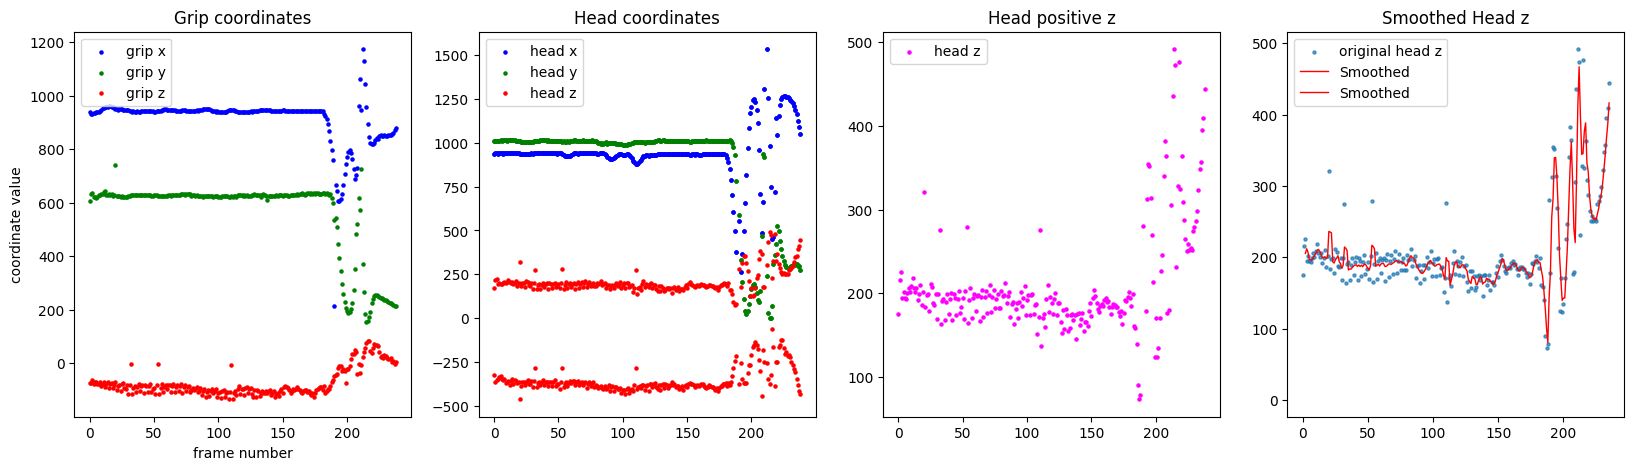

In [5]:
print(f"Radius = {radius}")
grip_coordinates = []
possible_head_coordinates = []
closer_z_coordinates = []

for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
    grip_coordinates.append(grip)

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[0]]])
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[1]]])
        closer_z_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [max(z_values)]])
    else:
        print(f"No real z solutions for i={i}")

import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

grip_coordinates = np.array(grip_coordinates)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 0], marker='o', color='blue', label='grip x', s = 5)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 1], marker='o', color='green', label='grip y', s = 5)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 2], marker='o', color='red', label='grip z', s = 5)


ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][0] for x in possible_head_coordinates], marker='o', color='blue', label='head x', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][1] for x in possible_head_coordinates], marker='o', color='green', label='head y', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)

ax2.scatter([x[0] for x in closer_z_coordinates], [x[1][2] for x in closer_z_coordinates], marker='o', color='fuchsia', label='head z', s = 5)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Sample data (replace this with your list of values)
data = [x[1][2] for x in closer_z_coordinates]

# Set the window size for the moving average
window_size = 3
# Smooth the data using the moving average function
smoothed_data = moving_average(data, window_size)
# Plot both the original and smoothed data
x_smoothed = np.arange(window_size - 1, len(data))

ax3.scatter(np.arange(len(data)), data, label='original head z', marker='o', alpha=0.7, s = 5)
ax3.plot(x_smoothed, smoothed_data, 1, label='Smoothed', linewidth=1, color = 'red')

ax0.set_xlabel('frame number')
ax0.set_ylabel('coordinate value')

# Add title and axis labels
for ax, title in zip([ax0, ax1, ax2, ax3], ['Grip coordinates', 'Head coordinates', 'Head positive z', 'Smoothed Head z']):
    ax.set_title(title)
    ax.legend(loc="upper left")

plt.show()

In [6]:
import math
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import subprocess as sp

def get_resolution(filename):
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            
def get_fps(filename):
    """Returns the fps of the video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=r_frame_rate', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            a, b = line.decode().strip().split('/')
            return int(a) / int(b)

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))

In [7]:
print(f"Radius = {radius}")
adjusted_poses = []
club_coordinates = []

for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)
    adjusted_poses.append(pos)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        head = list(frame_club_2d_keypoints[1]) + [max(z_values)]
        club_coordinates.append([grip, head])
    else:
        club_coordinates.append([grip, club_coordinates[-1][1]])
adjusted_poses = np.array(adjusted_poses)
club_coordinates = np.array(club_coordinates)

Radius = 474.6


In [8]:
min_max_values = []
for dim in range(3):
    body_min_value, body_max_value = np.sort([x.min() for x in adjusted_poses[..., dim]])[5], np.sort([x.max() for x in adjusted_poses[..., dim]])[-5]
    club_min_value, club_max_value = np.sort([x.min() for x in club_coordinates[..., dim]])[5], np.sort([x.max() for x in club_coordinates[..., dim]])[-5]
    min_value = min(body_min_value, club_min_value)
    max_value = max(body_max_value, club_max_value)
    min_max_values.append([min_value, max_value])
min_max_values = np.array(min_max_values)
print("min_max values", min_max_values)

min_max values [[ 453.         1265.        ]
 [  39.         1015.        ]
 [-164.97950745  436.32579767]]


In [25]:
!rm -rf frames

In [26]:
import os
if not os.path.exists('frames'):
    os.makedirs('frames')

# %matplotlib inline
i = 180 #frame number
size = 6

# Load video using ffmpeg
for f in read_video('videos/output.mp4', skip = i):
    frame = f

    pos = adjusted_poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    club_3d_keypoints = club_coordinates[i].copy()

    # plt.clf() 
    fig = plt.figure(figsize=(2*size, size)) # 6x6

    ax_in = fig.add_subplot(1, 2, 1)
    # ax_in.get_xaxis().set_visible(False)
    # ax_in.get_yaxis().set_visible(False)
    ax_in.set_xlabel('X')
    ax_in.set_ylabel('Y')
    # ax_in.set_axis_off()
    ax_in.set_title('Input')

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.set_xlim3d(min_max_values[0])
    ax.set_zlim3d(min_max_values[1])
    ax.set_ylim3d(min_max_values[:, 0].min(), min_max_values[:, 1].max())

    ax.set_aspect('equal')
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Reconstruction")

    # Update 2D poses
    joints_right_2d = keypoints_symmetry[1]
    colors_2d = np.full(keypoints.shape[1], 'black')
    colors_2d[joints_right_2d] = 'red'
    image = ax_in.imshow(frame, aspect='equal')

    for j, j_parent in enumerate(skeleton_parents):
        if j_parent == -1:
            continue
            
        col = 'red' if j in joints_right else 'black'
        
        ax.plot([pos[j, 0], pos[j_parent, 0]],
                    [pos[j, 1], pos[j_parent, 1]],
                    [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)


    #plot points which show on both
    #3d points which have a bijection to 2d points
    # ax.scatter(*pos[valid_pairings[:, 0]].T, color = ['red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'red', 'red'])
    #projected 3d to 2d keypoints
    # ax_in.scatter(*pos[valid_pairings[:, 0]][:, :2].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='fuchsia', zorder=10)

    #2d keypoints (from detectron2) to display
    ax_in.scatter(*frame_2d_keypoints[valid_pairings[:, 1]].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='white', zorder=10)

    # #Plotting club:
    # grip, head = club_3d_keypoints
    ax_in.scatter(*club_3d_keypoints[:, :2].T, 10, color='blue', edgecolors='white', zorder=10)
    ax_in.plot(*club_3d_keypoints[:, :2].T, linestyle = 'dashed', color = 'white')

    ax.scatter(*club_3d_keypoints.T, zdir='z', color='blue', edgecolors='white', zorder=10)
    ax.plot(*club_3d_keypoints.T, zdir='z', c = 'blue')

    ax.view_init(elev=90., azim=90) # Note Y axis increases as it goes down on image so need to rotate 3d plot
    ax.invert_xaxis()
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'frames/{i}.jpg')
    plt.close()
    print(f"Saved frame: {i}")
    i += 1
# plt.show()

Saved frame: 180
Saved frame: 181
Saved frame: 182
Saved frame: 183
Saved frame: 184
Saved frame: 185
Saved frame: 186
Saved frame: 187
Saved frame: 188
Saved frame: 189
Saved frame: 190
Saved frame: 191
Saved frame: 192
Saved frame: 193
Saved frame: 194
Saved frame: 195
Saved frame: 196
Saved frame: 197
Saved frame: 198
Saved frame: 199
Saved frame: 200
Saved frame: 201
Saved frame: 202
Saved frame: 203
Saved frame: 204
Saved frame: 205
Saved frame: 206
Saved frame: 207
Saved frame: 208
Saved frame: 209
Saved frame: 210
Saved frame: 211
Saved frame: 212
Saved frame: 213
Saved frame: 214
Saved frame: 215
Saved frame: 216
Saved frame: 217
Saved frame: 218
Saved frame: 219
Saved frame: 220
Saved frame: 221
Saved frame: 222
Saved frame: 223
Saved frame: 224
Saved frame: 225
Saved frame: 226
Saved frame: 227
Saved frame: 228
Saved frame: 229
Saved frame: 230
Saved frame: 231
Saved frame: 232
Saved frame: 233
Saved frame: 234
Saved frame: 235
Saved frame: 236
Saved frame: 237
Saved frame: 2

In [18]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
!cd frames && ffmpeg -start_number 180 -framerate 5 -i %d.jpg \
  -c:v libx264 -pix_fmt yuv420p golf_3d_pose.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [28]:
!mv frames/golf_3d_pose.mp4 golf_3d_pose.mp4